<a href="https://colab.research.google.com/github/VKSi/2020_11_GB_TimeSeries/blob/main/HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Временные ряды 2. Преобразование признаков 

# Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибки моделей из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

## Ответы

### Задание №1

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 

In [ ]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [ ]:
data.tail()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2018-08-02,20:00:00,44057.0,2018,8,2,3,214,31,3,20,0,0,0
2018-08-02,21:00:00,43256.0,2018,8,2,3,214,31,3,21,0,0,0
2018-08-02,22:00:00,41552.0,2018,8,2,3,214,31,3,22,0,0,0
2018-08-02,23:00:00,38500.0,2018,8,2,3,214,31,3,23,0,0,0
2018-08-03,00:00:00,35486.0,2018,8,3,3,215,31,4,0,0,0,0


Переиндексируем наблюдения по часам и выделим только первичные данные:

На всякий случай отсортируем данные:

In [ ]:
data = data.sort_values(by=['year', 'month', 'dayofmonth'], axis = 'index')
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


По хорошему нужно здесь проверить пропуски и дупликаты, но делать этого не будем, поверим владельцу данных (преподаватель)

In [ ]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
date_time.head()

2002-01-01 00:00:00    30393.0
2002-01-01 01:00:00    29265.0
2002-01-01 02:00:00    28357.0
2002-01-01 03:00:00    27899.0
2002-01-01 04:00:00    28057.0
Freq: H, Name: PJME_MW, dtype: float64

In [ ]:
time_values = pd.DataFrame(date_time)
time_values.rename(columns= {'PJME_MW':'values'}, inplace = True)
time_values.values = time_values.values.astype('int')
time_values.head()

,values
2002-01-01 00:00:00,30393
2002-01-01 01:00:00,29265
2002-01-01 02:00:00,28357
2002-01-01 03:00:00,27899
2002-01-01 04:00:00,28057


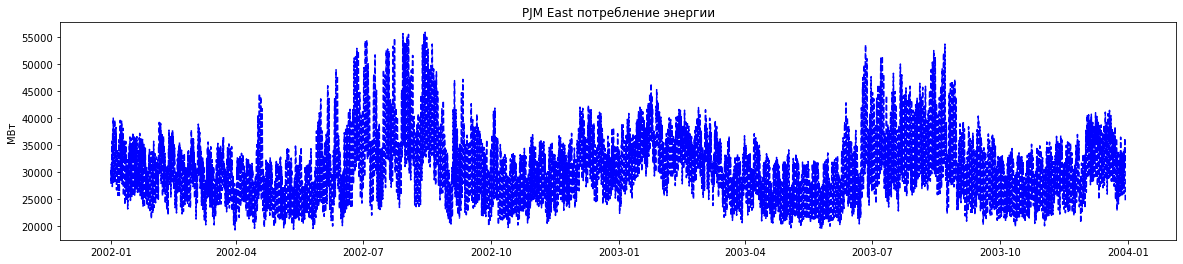

In [ ]:
plt.figure(figsize =(20,4))
plt.plot( time_values.index[:24*7*104], time_values.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [ ]:
time_values.shape

(145374, 1)

Используем функцию экспоненциального сглаживания из лекции:

In [ ]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # the first value is the same as in the series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

Сгладим данние с весовым коэффициентом 0.1

In [ ]:
time_values.values = exponential_smoothing(time_values.values, 0.1)

In [ ]:
time_values.shape

(145374, 1)

Используем также функцию деления датасета на части:

In [ ]:
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [ ]:
split_date = '01-03-2017'

In [ ]:
train, test = split_data(time_values, split_date)

In [ ]:
print(f'test: {test.shape[0]} observations, total: {train.shape[0] + test.shape[0]} observations')

test: 13829 observations, total: 145374 observations


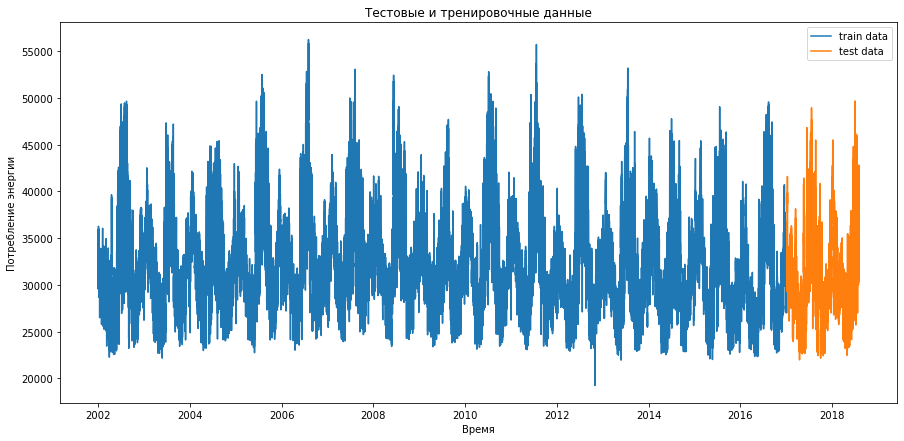

In [ ]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index, train.values, label='train data' )
plt.plot(test.index, test.values, label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

Также нам понадобится функция оценки качества модели:

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

Функция для построения модели:

In [ ]:
def gbm(h, train= train, test= test):
    X_train = train.iloc[:-h,:]
    y_train = train.values[h:].ravel()
    X_test = test.iloc[:-h,:]
    y_test = test.values[h:].ravel()

    model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
    model_gb.fit(X_train, y_train) 
    X_test_pred_gb = model_gb.predict(X_test)
    
    return model_gb, y_test, X_test_pred_gb

In [ ]:
model_gb_1, y_test_1, X_test_pred_gb_1 = gbm(h=1)

In [ ]:
model_gb_10, y_test_10, X_test_pred_gb_10 = gbm(h=10)

In [ ]:
def display_pred(h=1, y_test=y_test_1, X_test_pred_gb=X_test_pred_gb_1):
    plt.figure( figsize=( 20, 4 ))

    plt.xlabel('Время')
    plt.ylabel('Значение наблюдаемого параметра')
    plt.plot(test.index[h:], X_test_pred_gb, label='prediction', alpha=0.6)
    plt.plot(test.index[h:], y_test, label='test data', alpha=0.6)

    plt.legend()
    plt.show()

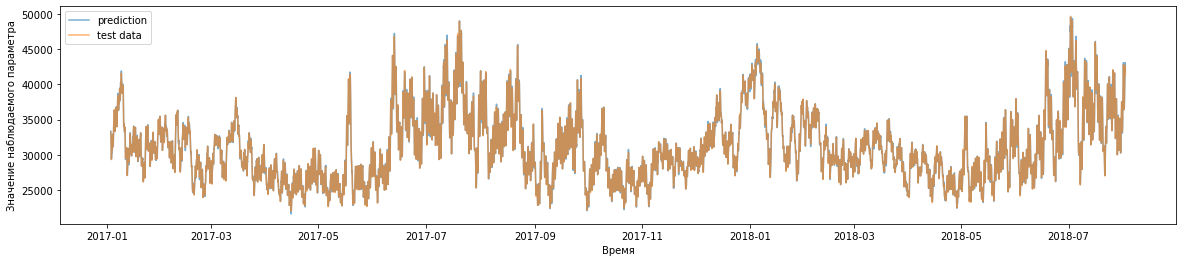

In [ ]:
display_pred(h=1, y_test=y_test_1, X_test_pred_gb=X_test_pred_gb_1)

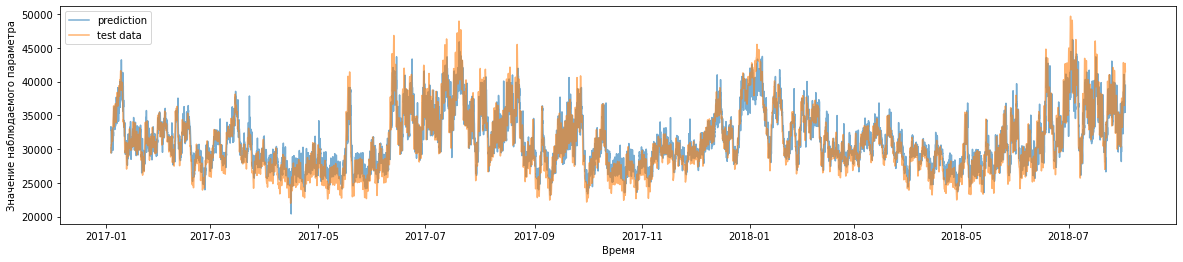

In [ ]:
display_pred(h=10, y_test=y_test_10, X_test_pred_gb=X_test_pred_gb_10)

### Задание №2

2. Оцените ошибки моделей из п.1 .

In [ ]:
er_g = mean_absolute_percentage_error(y_true = y_test_1, y_pred = X_test_pred_gb_1)
print(f'Ошибка градиентного бустинга при h=1: {er_g[0]}%')

Ошибка градиентного бустинга при h=1: 1.0804066321996268%


In [ ]:
er_g = mean_absolute_percentage_error(y_true = y_test_10, y_pred = X_test_pred_gb_10)
print(f'Ошибка градиентного бустинга при h=10: {er_g[0]}%')

Ошибка градиентного бустинга при h=10: 6.99991059684878%


#### Факультативно:

На мой взгляд предложенная оценка ошибки при применении к предсказанию средней (сглаженной) величины не корректно отображает качество модели, так как не учитывает того, что в значение y_true частично входит информация из X_test (то же самое для train). Процент отклонения следует считать, указаывая в знаменателе не полное значение y_pred, а только ту часть, которая является новой по отношению к X_test.     

Посмотрим на примере h=1. Так как любое значение y[n] = alpha * original_data[n] + (1 - alpha) * y[n-1], в то время как y[n-1] входит в состав X и предсказание этой части рне требует модели (так как может быть сосчитано просто по определению), в знаменатель оценки ошибки следует поместить не y_true, a только alpha * original_data[n]. Для h=1 мы можем сосчитать это значение обратным расчетом: new_information = y[n] - (1 - alpha) * y[n-1].     

Для значений h > 1 расчет будет более сложный, так как новой информацией являются h последних членов, а не только 1, но его логика останется той же самой.

In [ ]:
def mean_absolute_percentage_error_corrected(y_true, y_pred, y_true_prev, alpha): 
    y_true, y_pred, y_true_prev = np.array(y_true), np.array(y_pred), np.array(y_true_prev)
    return np.mean(np.abs((y_true - y_pred) / (y_true - y_true_prev * (1 - alpha)))) * 100

In [ ]:
y_true_prev_1 = test.values[:-1].ravel()

In [ ]:
er_g = mean_absolute_percentage_error_corrected(y_true = y_test_1, y_pred = X_test_pred_gb_1, y_true_prev = y_true_prev_1, alpha = 0.1)
print(f'Скорректированная ошибка градиентного бустинга при h=1: {er_g[0]}%')

Скорректированная ошибка градиентного бустинга при h=1: 11.24615669967576%


Видно, что реальная ошибка модели (в той части, в которой она действительно зависит от модели) в 10 раз выше, чем было расчитано до этого

### Задание №3

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Ошибка модели увеличилась для бОльшего h

### Задание №4

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

Стационарность подразумевает постоянство :
- Мат.ожидания
- Дисперсии
- автоковариация стационарного ряда с лагом L
- коэффициент автокорреляция стационарного ряда с лагом L

    а) Изменение температуры за окном :).
    Имеет сезонность, тренд (глобальное потепление), дневные циклы. Не стационарен

    б) Количество денег, которые тратят покупатели в интернет магазине.     
    (в целом может зависеть от магазина). Процесс не стационарный, есть рост в праздничные и предпраздничные дни, январское затишье и так далее. Тренд может присутствовать при росте популярности. Сезонность может присутствовать, например по сезонным товарам. Циклы могут присутствовать, например связанные с экономическими циклами.    

    в) Вес растущего котенка.
    Если он не котенок Шредингера и мы о нем что-то знаем, то скорее всего он растет. Это тренд. Есть внутредневная цикличность (поел, сходил в туалет). Нестационарный процесс.

    г) Прирост объема деревьев в лесу от времени    
    В молодом лесу есть тренд - количество и размер деревьев растет. В старом лесу тренда наверное нет. Сезонность есть (не ботаник, но подозреваю). Наверное есть дневная цикличность (они же растут на солнышке или ночью тоже?)